<a href="https://colab.research.google.com/github/movinduhiripitiya/my-first-repo/blob/main/EN3150_Assignment_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1:CNN for image classification

# Task 1: Setting up the environment

In [ ]:
# 1.1:Installing and Importing Required Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
import seaborn as sns
import pathlib
import os

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: []


# Task 2: Preparing the dataset

Skipping, found downloaded files in "./surface-crack-detection" (use force=True to force download)
Total images: 40000
Classes: ['Negative', 'Positive']
Negative: 20000 images
Positive: 20000 images


<Figure size 1200x800 with 0 Axes>

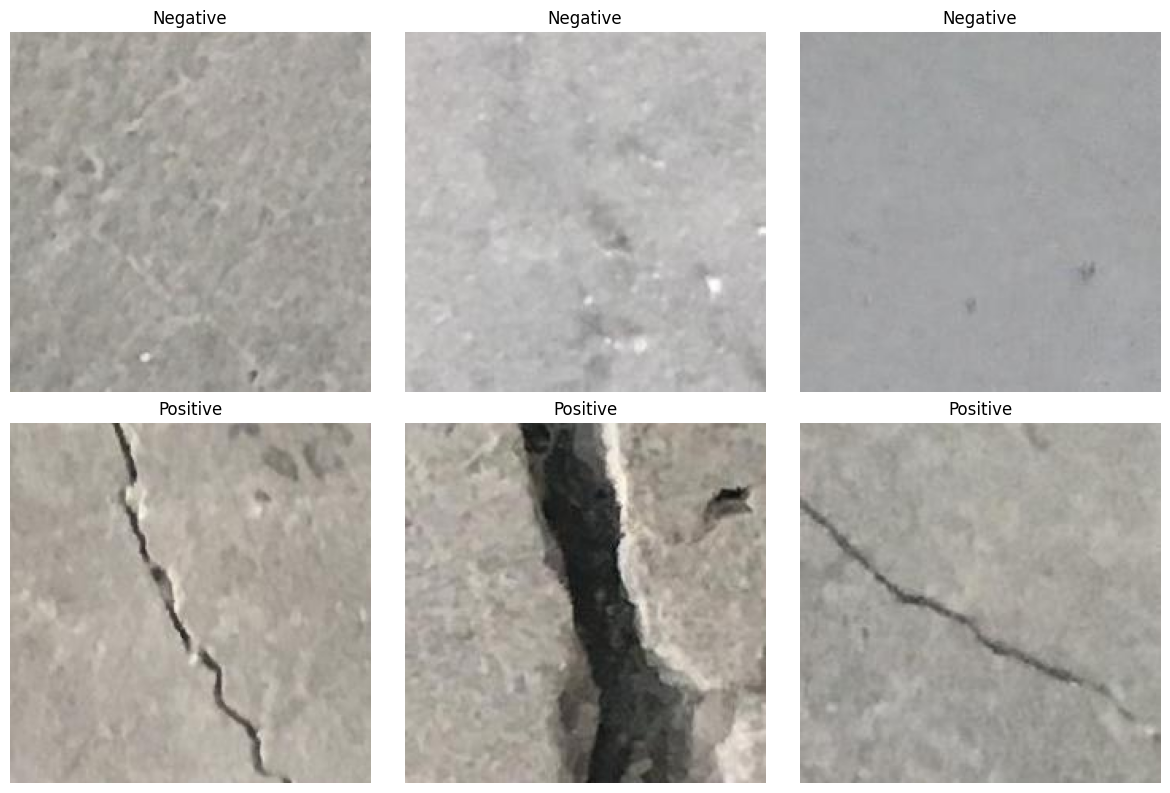

In [ ]:
!pip install opendatasets
# 2.1:Installing and Importing Required Libraries for Downloading Process
import opendatasets as od
import pathlib

#2.2: Downloading the Dataset (if not already downloaded)
od.download("https://www.kaggle.com/datasets/arunrk7/surface-crack-detection")

#2.3:Setting the Data Directory Path to the Downloaded Folder
data_dir = pathlib.Path('surface-crack-detection')

#2.4:Exploring the Dataset
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png')))
print(f"Total images: {image_count}")

#2.5:Getting the Class names
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print(f"Classes: {class_names}")

#2.6:Counting Images Per Class
for class_name in class_names:
    class_path = data_dir / class_name
    class_count = len(list(class_path.glob('*.jpg'))) + len(list(class_path.glob('*.png')))
    print(f"{class_name}: {class_count} images")

#2.7:Visualizing Sample Images
    plt.figure(figsize=(12, 8))
for idx, class_name in enumerate(class_names):
    class_path = data_dir / class_name
    images = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))

    for i in range(3):
        plt.subplot(len(class_names), 3, idx * 3 + i + 1)
        img = plt.imread(str(images[i]))
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
plt.tight_layout()
plt.show()

#5c4ecbc7e18fddbcf72ebb32729256f4

#Task 3: Data Splitting and Loading

In [ ]:
#3.1:Defining Parameters
batch_size = 32
img_height = 128  # Standard size for transfer learning
img_width = 128
seed = 123

# Note: The dataset should be organized in folders by class
# We'll use 70% training, 15% validation, 15% test

#3.2:Creating Training Dataset (70%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # 30% for validation + test
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

#3.3:Creating Validation and Test Datasets (15% each)
# First, get the remaining 30%
temp_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

#3.4:Splitting the 30% into two equal parts (15% validation, 15% test)
temp_size = tf.data.experimental.cardinality(temp_ds).numpy()
val_size = temp_size // 2

val_ds = temp_ds.take(val_size)
test_ds = temp_ds.skip(val_size)

print(f"Training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

#3.5:Configuring Dataset for Performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 40000 files belonging to 2 classes.
Using 28000 files for training.
Class names: ['Negative', 'Positive']
Number of classes: 2
Found 40000 files belonging to 2 classes.
Using 12000 files for validation.
Training batches: 875
Validation batches: 187
Test batches: 188


# Task 4:Building the CNN model

In [ ]:
# 4.1: Defining Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# 4.2: Building Custom CNN Architecture
"""
ARCHITECTURE JUSTIFICATIONS:

1. ACTIVATION FUNCTIONS:
   - ReLU for hidden layers: Addresses vanishing gradient problem, computationally efficient,
     and has been proven effective for image classification tasks
   - Softmax for output: Converts logits to probability distribution for multi-class classification

2. FILTER SIZES: Progressive increase (32 -> 64 -> 128)
   - Lower layers detect simple features (edges, colors)
   - Higher layers detect complex patterns (cracks, textures)

3. KERNEL SIZE: 3x3
   - Standard choice that balances receptive field and computational efficiency
   - Captures local spatial patterns effectively

4. DROPOUT RATE: 0.5
   - Prevents overfitting by randomly dropping 50% of connections during training
   - Standard rate for image classification tasks

5. FULLY CONNECTED LAYER: 256 units
   - Sufficient capacity to learn complex decision boundaries
   - Not too large to avoid overfitting on this dataset
"""

def create_custom_cnn(input_shape=(img_height, img_width, 3), num_classes=2):
    model = Sequential([
        # Data augmentation (active only during training)
        data_augmentation,

        # Normalization
        layers.Rescaling(1./255, input_shape=input_shape),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3'),
        layers.MaxPooling2D((2, 2), name='pool3'),

        # Flatten and Dense Layers
        layers.Flatten(name='flatten'),
        layers.Dense(256, activation='relu', name='fc1'),
        layers.Dropout(0.5, name='dropout'),

        # Output Layer
        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    return model

# Creating the Model
custom_model = create_custom_cnn(num_classes=num_classes)

# BUILD THE MODEL FIRST (This is the fix!)
custom_model.build(input_shape=(None, img_height, img_width, 3))

# Now show the summary
custom_model.summary()

# 4.3: Visualize Model Architecture
tf.keras.utils.plot_model(
    custom_model,
    to_file='custom_cnn_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

print("✓ Model architecture diagram saved as 'custom_cnn_architecture.png'")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

✓ Model architecture diagram saved as 'custom_cnn_architecture.png'


#Task 7: Training with Different Optimizers

In [ ]:
# ============================================================================
# TRAINING SESSION 1: ADAM OPTIMIZER
# ============================================================================

import gc
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

print("="*80)
print("TRAINING SESSION 1: ADAM OPTIMIZER")
print("="*80)

# Define parameters
learning_rate = 0.001
epochs = 20

# Callbacks
callbacks_adam = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# Create model
print("\nCreating Custom CNN with Adam optimizer...")
custom_model_adam = create_custom_cnn(num_classes=num_classes)
custom_model_adam.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
custom_model_adam.summary()

# Train
print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)

history_adam = custom_model_adam.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_adam,
    verbose=1
)

# Save model
print("\n" + "="*80)
print("SAVING MODEL...")
print("="*80)

custom_model_adam.save('custom_cnn_adam.h5')
print("✓ Model saved as 'custom_cnn_adam.h5'")

# Save training history as CSV
import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, len(history_adam.history['accuracy']) + 1),
    'train_accuracy': history_adam.history['accuracy'],
    'val_accuracy': history_adam.history['val_accuracy'],
    'train_loss': history_adam.history['loss'],
    'val_loss': history_adam.history['val_loss']
})

history_df.to_csv('history_adam.csv', index=False)
print("✓ Training history saved as 'history_adam.csv'")

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_adam.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_adam.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Adam Optimizer - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_adam.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_adam.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Adam Optimizer - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_adam.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plot saved as 'training_adam.png'")

# Print summary
print("\n" + "="*80)
print("TRAINING COMPLETE - ADAM OPTIMIZER")
print("="*80)
print(f"Final Training Accuracy: {history_adam.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_adam.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history_adam.history['val_accuracy']):.4f}")
print(f"Final Training Loss: {history_adam.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_adam.history['val_loss'][-1]:.4f}")
print("="*80)

# Download files (optional - uncomment if needed)
# from google.colab import files
# files.download('custom_cnn_adam.h5')
# files.download('history_adam.csv')
# files.download('training_adam.png')

# Clear memory
print("\nClearing memory...")
del custom_model_adam
K.clear_session()
gc.collect()
print("✓ Memory cleared")
print("\n⚠️  IMPORTANT: You can now move to the next training session (SGD)")

TRAINING SESSION 1: ADAM OPTIMIZER

Creating Custom CNN with Adam optimizer...

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)


STARTING TRAINING...
Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 1305s 1s/step - accuracy: 0.9079 - loss: 0.2251 - val_accuracy: 0.9886 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 2/20
210/875 ━━━━━━━━━━━━━━━━━━━━ 15:16 1s/step - accuracy: 0.9862 - loss: 0.0631

KeyboardInterrupt: 

In [ ]:
# ============================================================================
# TRAINING SESSION 2: STANDARD SGD OPTIMIZER
# ============================================================================

import gc
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

print("="*80)
print("TRAINING SESSION 2: STANDARD SGD OPTIMIZER")
print("="*80)

# Define parameters
learning_rate = 0.001
epochs = 20

# Callbacks
callbacks_sgd = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# Create model
print("\nCreating Custom CNN with SGD optimizer...")
custom_model_sgd = create_custom_cnn(num_classes=num_classes)
custom_model_sgd.compile(
    optimizer=SGD(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
custom_model_sgd.summary()

# Train
print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)

history_sgd = custom_model_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_sgd,
    verbose=1
)

# Save model
print("\n" + "="*80)
print("SAVING MODEL...")
print("="*80)

custom_model_sgd.save('custom_cnn_sgd.h5')
print("✓ Model saved as 'custom_cnn_sgd.h5'")

# Save training history as CSV
import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, len(history_sgd.history['accuracy']) + 1),
    'train_accuracy': history_sgd.history['accuracy'],
    'val_accuracy': history_sgd.history['val_accuracy'],
    'train_loss': history_sgd.history['loss'],
    'val_loss': history_sgd.history['val_loss']
})

history_df.to_csv('history_sgd.csv', index=False)
print("✓ Training history saved as 'history_sgd.csv'")

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_sgd.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_sgd.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('SGD Optimizer - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_sgd.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_sgd.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('SGD Optimizer - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_sgd.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plot saved as 'training_sgd.png'")

# Print summary
print("\n" + "="*80)
print("TRAINING COMPLETE - STANDARD SGD OPTIMIZER")
print("="*80)
print(f"Final Training Accuracy: {history_sgd.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_sgd.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history_sgd.history['val_accuracy']):.4f}")
print(f"Final Training Loss: {history_sgd.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_sgd.history['val_loss'][-1]:.4f}")
print("="*80)

# Download files (optional - uncomment if needed)
# from google.colab import files
# files.download('custom_cnn_sgd.h5')
# files.download('history_sgd.csv')
# files.download('training_sgd.png')

# Clear memory
print("\nClearing memory...")
del custom_model_sgd
K.clear_session()
gc.collect()
print("✓ Memory cleared")
print("\n⚠️  IMPORTANT: You can now move to the next training session (SGD + Momentum)")

TRAINING SESSION 2: STANDARD SGD OPTIMIZER


NameError: name 'keras' is not defined

In [ ]:
# ============================================================================
# TRAINING SESSION 3: SGD WITH MOMENTUM
# ============================================================================

import gc
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD

print("="*80)
print("TRAINING SESSION 3: SGD WITH MOMENTUM")
print("="*80)

"""
TASK 11: MOMENTUM PARAMETER IMPACT

Momentum helps accelerate SGD in relevant directions and dampens oscillations.
- Typical values: 0.9 or 0.95
- Helps escape local minima
- Reduces oscillations in optimization path
- Generally improves convergence speed

We'll test momentum = 0.9
"""

# Define parameters
learning_rate = 0.001
momentum_value = 0.9
epochs = 20

# Callbacks
callbacks_momentum = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7
    )
]

# Create model
print(f"\nCreating Custom CNN with SGD optimizer (momentum={momentum_value})...")
custom_model_sgd_momentum = create_custom_cnn(num_classes=num_classes)
custom_model_sgd_momentum.compile(
    optimizer=SGD(learning_rate=learning_rate, momentum=momentum_value),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
custom_model_sgd_momentum.summary()

# Train
print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)

history_sgd_momentum = custom_model_sgd_momentum.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks_momentum,
    verbose=1
)

# Save model
print("\n" + "="*80)
print("SAVING MODEL...")
print("="*80)

custom_model_sgd_momentum.save('custom_cnn_sgd_momentum.h5')
print("✓ Model saved as 'custom_cnn_sgd_momentum.h5'")

# Save training history as CSV
import pandas as pd

history_df = pd.DataFrame({
    'epoch': range(1, len(history_sgd_momentum.history['accuracy']) + 1),
    'train_accuracy': history_sgd_momentum.history['accuracy'],
    'val_accuracy': history_sgd_momentum.history['val_accuracy'],
    'train_loss': history_sgd_momentum.history['loss'],
    'val_loss': history_sgd_momentum.history['val_loss']
})

history_df.to_csv('history_sgd_momentum.csv', index=False)
print("✓ Training history saved as 'history_sgd_momentum.csv'")

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_sgd_momentum.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_sgd_momentum.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('SGD + Momentum - Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_sgd_momentum.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_sgd_momentum.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('SGD + Momentum - Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_sgd_momentum.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plot saved as 'training_sgd_momentum.png'")

# Print summary
print("\n" + "="*80)
print("TRAINING COMPLETE - SGD WITH MOMENTUM")
print("="*80)
print(f"Final Training Accuracy: {history_sgd_momentum.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_sgd_momentum.history['val_accuracy'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(history_sgd_momentum.history['val_accuracy']):.4f}")
print(f"Final Training Loss: {history_sgd_momentum.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history_sgd_momentum.history['val_loss'][-1]:.4f}")
print("="*80)

# Download files (optional - uncomment if needed)
# from google.colab import files
# files.download('custom_cnn_sgd_momentum.h5')
# files.download('history_sgd_momentum.csv')
# files.download('training_sgd_momentum.png')

# Clear memory
print("\nClearing memory...")
del custom_model_sgd_momentum
K.clear_session()
gc.collect()
print("✓ Memory cleared")
print("\n✅ ALL OPTIMIZER TRAINING SESSIONS COMPLETE!")

TRAINING SESSION 3: SGD WITH MOMENTUM

Creating Custom CNN with SGD optimizer (momentum=0.9)...

Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)


STARTING TRAINING...
Epoch 1/20
299/875 ━━━━━━━━━━━━━━━━━━━━ 12:44 1s/step - accuracy: 0.5335 - loss: 0.6925

LOADING AND COMPARING ALL TRAINING HISTORIES


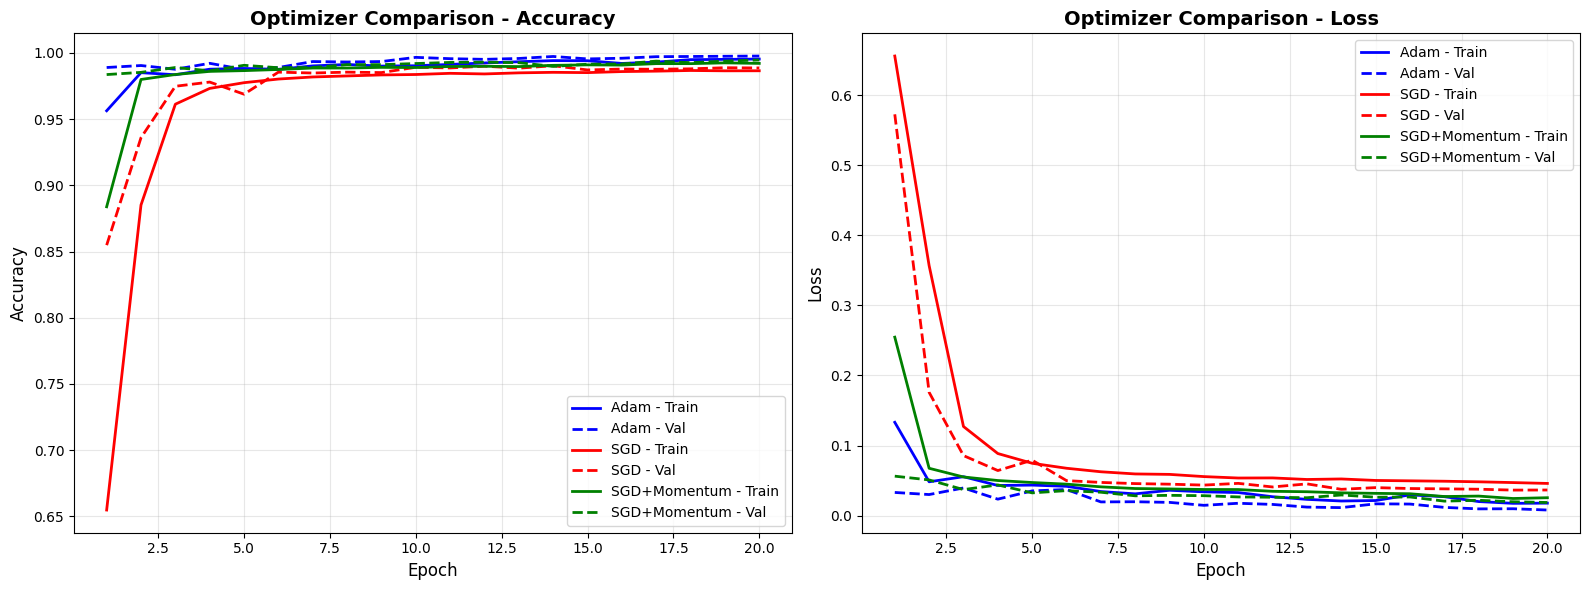

✓ Comparison plot saved as 'optimizer_comparison.png'

OPTIMIZER COMPARISON SUMMARY
     Optimizer  Final Train Acc  Final Val Acc  Best Val Acc  Final Train Loss  Final Val Loss
          Adam         0.995393       0.997667      0.997667          0.017755        0.007926
           SGD         0.986536       0.988667      0.990333          0.045890        0.036510
SGD + Momentum         0.992107       0.994667      0.994667          0.025490        0.018684

✓ Comparison table saved as 'optimizer_comparison.csv'

MOMENTUM IMPACT ANALYSIS
SGD Final Val Accuracy: 0.9887
SGD+Momentum Final Val Accuracy: 0.9947
Improvement: 0.61%

✅ ALL COMPARISONS COMPLETE!


In [ ]:
# ============================================================================
# COMPARISON OF ALL OPTIMIZERS
# ============================================================================

import pandas as pd
import matplotlib.pyplot as plt

print("="*80)
print("LOADING AND COMPARING ALL TRAINING HISTORIES")
print("="*80)

# Load all saved histories
history_adam_df = pd.read_csv('history_adam.csv')
history_sgd_df = pd.read_csv('history_sgd.csv')
history_sgd_momentum_df = pd.read_csv('history_sgd_momentum.csv')

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy comparison
axes[0].plot(history_adam_df['epoch'], history_adam_df['train_accuracy'],
             'b-', label='Adam - Train', linewidth=2)
axes[0].plot(history_adam_df['epoch'], history_adam_df['val_accuracy'],
             'b--', label='Adam - Val', linewidth=2)
axes[0].plot(history_sgd_df['epoch'], history_sgd_df['train_accuracy'],
             'r-', label='SGD - Train', linewidth=2)
axes[0].plot(history_sgd_df['epoch'], history_sgd_df['val_accuracy'],
             'r--', label='SGD - Val', linewidth=2)
axes[0].plot(history_sgd_momentum_df['epoch'], history_sgd_momentum_df['train_accuracy'],
             'g-', label='SGD+Momentum - Train', linewidth=2)
axes[0].plot(history_sgd_momentum_df['epoch'], history_sgd_momentum_df['val_accuracy'],
             'g--', label='SGD+Momentum - Val', linewidth=2)
axes[0].set_title('Optimizer Comparison - Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Loss comparison
axes[1].plot(history_adam_df['epoch'], history_adam_df['train_loss'],
             'b-', label='Adam - Train', linewidth=2)
axes[1].plot(history_adam_df['epoch'], history_adam_df['val_loss'],
             'b--', label='Adam - Val', linewidth=2)
axes[1].plot(history_sgd_df['epoch'], history_sgd_df['train_loss'],
             'r-', label='SGD - Train', linewidth=2)
axes[1].plot(history_sgd_df['epoch'], history_sgd_df['val_loss'],
             'r--', label='SGD - Val', linewidth=2)
axes[1].plot(history_sgd_momentum_df['epoch'], history_sgd_momentum_df['train_loss'],
             'g-', label='SGD+Momentum - Train', linewidth=2)
axes[1].plot(history_sgd_momentum_df['epoch'], history_sgd_momentum_df['val_loss'],
             'g--', label='SGD+Momentum - Val', linewidth=2)
axes[1].set_title('Optimizer Comparison - Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('optimizer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison plot saved as 'optimizer_comparison.png'")

# Create comparison table
comparison_data = {
    'Optimizer': ['Adam', 'SGD', 'SGD + Momentum'],
    'Final Train Acc': [
        history_adam_df['train_accuracy'].iloc[-1],
        history_sgd_df['train_accuracy'].iloc[-1],
        history_sgd_momentum_df['train_accuracy'].iloc[-1]
    ],
    'Final Val Acc': [
        history_adam_df['val_accuracy'].iloc[-1],
        history_sgd_df['val_accuracy'].iloc[-1],
        history_sgd_momentum_df['val_accuracy'].iloc[-1]
    ],
    'Best Val Acc': [
        history_adam_df['val_accuracy'].max(),
        history_sgd_df['val_accuracy'].max(),
        history_sgd_momentum_df['val_accuracy'].max()
    ],
    'Final Train Loss': [
        history_adam_df['train_loss'].iloc[-1],
        history_sgd_df['train_loss'].iloc[-1],
        history_sgd_momentum_df['train_loss'].iloc[-1]
    ],
    'Final Val Loss': [
        history_adam_df['val_loss'].iloc[-1],
        history_sgd_df['val_loss'].iloc[-1],
        history_sgd_momentum_df['val_loss'].iloc[-1]
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("OPTIMIZER COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Save comparison table
comparison_df.to_csv('optimizer_comparison.csv', index=False)
print("\n✓ Comparison table saved as 'optimizer_comparison.csv'")

# Momentum impact analysis
sgd_val_acc = history_sgd_df['val_accuracy'].iloc[-1]
momentum_val_acc = history_sgd_momentum_df['val_accuracy'].iloc[-1]
improvement = ((momentum_val_acc - sgd_val_acc) / sgd_val_acc) * 100

print("\n" + "="*80)
print("MOMENTUM IMPACT ANALYSIS")
print("="*80)
print(f"SGD Final Val Accuracy: {sgd_val_acc:.4f}")
print(f"SGD+Momentum Final Val Accuracy: {momentum_val_acc:.4f}")
print(f"Improvement: {improvement:.2f}%")
print("="*80)

print("\n✅ ALL COMPARISONS COMPLETE!")

EVALUATING BEST MODEL (ADAM) ON TEST SET

Loading trained model...


✓ Model loaded successfully

Evaluating on test dataset...
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9963 - loss: 0.0081

TEST SET RESULTS
Test Accuracy: 0.9968 (99.68%)
Test Loss: 0.0088

Generating predictions...


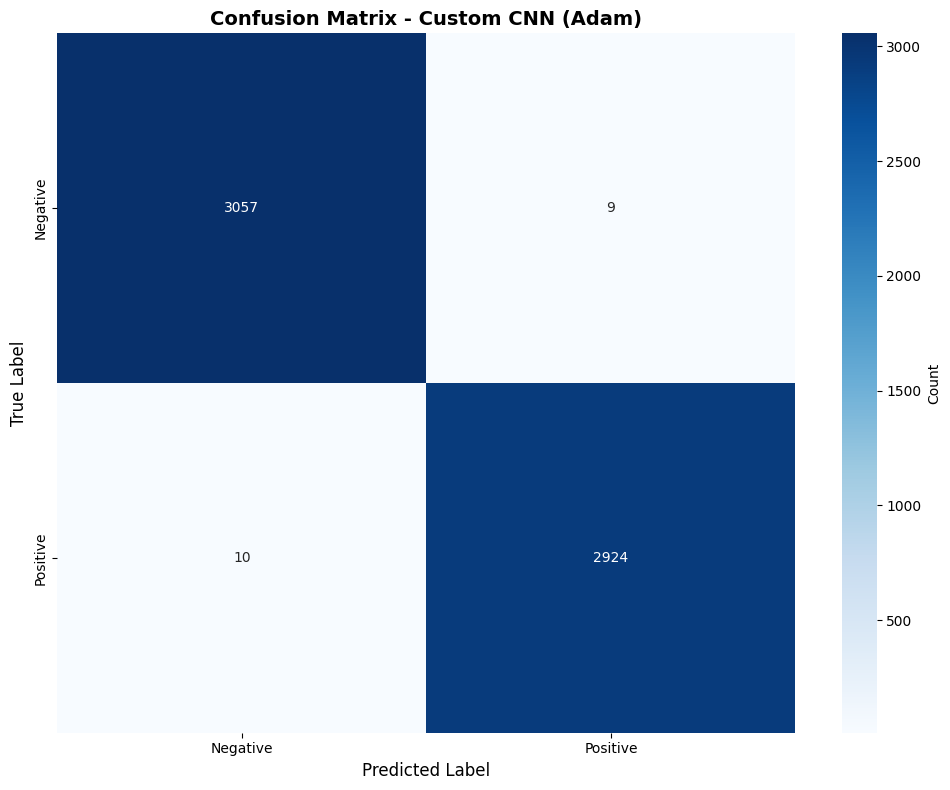

✓ Confusion matrix saved as 'confusion_matrix_adam.png'

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.9967    0.9971    0.9969      3066
    Positive     0.9969    0.9966    0.9968      2934

    accuracy                         0.9968      6000
   macro avg     0.9968    0.9968    0.9968      6000
weighted avg     0.9968    0.9968    0.9968      6000

WEIGHTED AVERAGE METRICS
Precision: 0.9968
Recall: 0.9968

✓ Results saved to 'test_results_adam.txt'

✅ EVALUATION COMPLETE!


In [ ]:
# ============================================================================
# EVALUATE BEST MODEL ON TEST SET
# ============================================================================

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

print("="*80)
print("EVALUATING BEST MODEL (ADAM) ON TEST SET")
print("="*80)

# Load the best model (Adam)
from tensorflow.keras.models import load_model

print("\nLoading trained model...")
best_model = load_model('custom_cnn_adam.h5')
print("✓ Model loaded successfully")

# Evaluate on test set
print("\nEvaluating on test dataset...")
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)

print("\n" + "="*80)
print("TEST SET RESULTS")
print("="*80)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")
print("="*80)

# Get predictions
print("\nGenerating predictions...")
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = best_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Custom CNN (Adam)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_adam.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved as 'confusion_matrix_adam.png'")

# Classification Report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
report = classification_report(y_true, y_pred,
                               target_names=class_names,
                               digits=4)
print(report)

# Calculate metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print("="*80)
print("WEIGHTED AVERAGE METRICS")
print("="*80)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("="*80)

# Save results
results_summary = f"""
TEST SET EVALUATION RESULTS
============================

Model: Custom CNN with Adam Optimizer
Test Accuracy: {test_accuracy:.4f}
Test Loss: {test_loss:.4f}
Weighted Precision: {precision:.4f}
Weighted Recall: {recall:.4f}

Confusion Matrix:
{cm}

Classification Report:
{report}
"""

with open('test_results_adam.txt', 'w') as f:
    f.write(results_summary)

print("\n✓ Results saved to 'test_results_adam.txt'")
print("\n✅ EVALUATION COMPLETE!")

#Task 12:Evaluating the Model

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9963 - loss: 0.0081

Test Accuracy: 0.9968
Test Loss: 0.0088


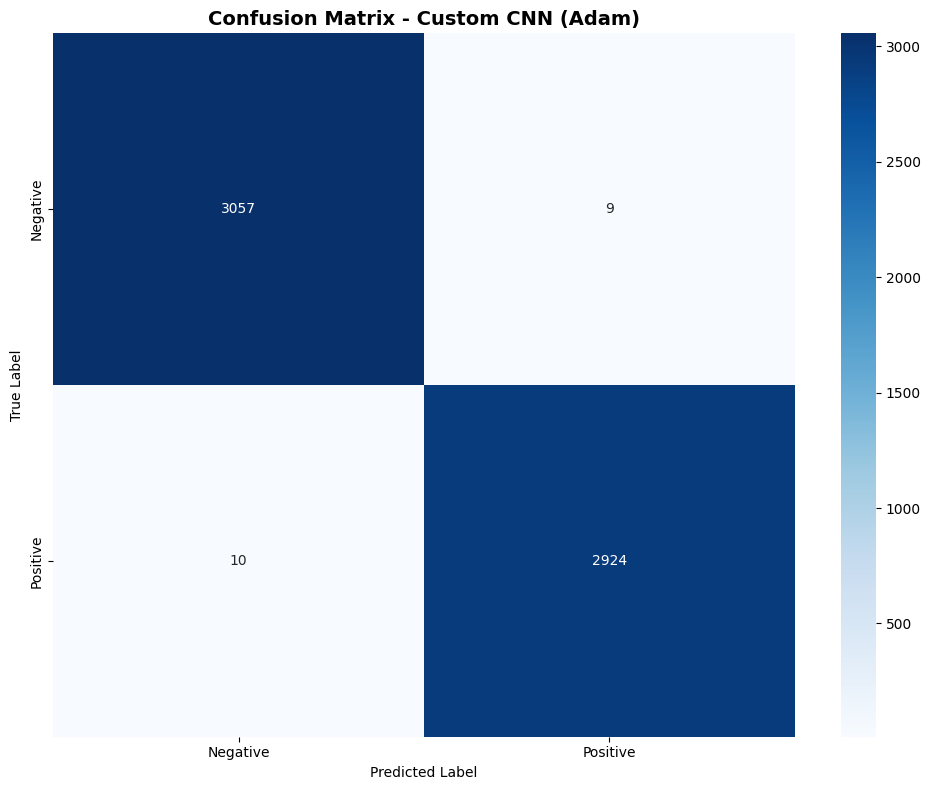


CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.9967    0.9971    0.9969      3066
    Positive     0.9969    0.9966    0.9968      2934

    accuracy                         0.9968      6000
   macro avg     0.9968    0.9968    0.9968      6000
weighted avg     0.9968    0.9968    0.9968      6000


Weighted Precision: 0.9968
Weighted Recall: 0.9968


In [ ]:
# Load best model
from tensorflow.keras.models import load_model

best_model = load_model('custom_cnn_adam.h5')

# Evaluate
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)

print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Get predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = best_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Custom CNN (Adam)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Classification Report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"\nWeighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print("="*80)

# Part 2:Comparing the network with state-of-the-art networks

#Task 14:Loading the pre-trained model and fine-tune it for our dataset.

In [ ]:
#14.1:Loading Pre-trained Models

"""
TASK 13: CHOOSING PRE-TRAINED MODELS

Selected Models:
1. ResNet50 - Deep residual network with skip connections
2. EfficientNetB0 - Efficient architecture with compound scaling

Why these models:
- Both are state-of-the-art for image classification
- Pre-trained on ImageNet (1.2M images, 1000 classes)
- Different architectural approaches (residual vs efficient)
- Good balance between accuracy and computational efficiency
"""

from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# 14.2:Creating ResNet50 Transfer Learning Model
def create_transfer_model_resnet(input_shape=(img_height, img_width, 3), num_classes=2):
    """
    Create transfer learning model using ResNet50
    """
    # Load pre-trained ResNet50 (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Add custom classification head
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./127.5, offset=-1),  # ResNet preprocessing
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

resnet_model, resnet_base = create_transfer_model_resnet(num_classes=num_classes)
resnet_model.summary()

# 14.3:Creating EfficientNetB0 Transfer Learning Model
def create_transfer_model_efficientnet(input_shape=(img_height, img_width, 3), num_classes=2):
    """
    Create transfer learning model using EfficientNetB0
    """
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Add custom classification head
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255),  # EfficientNet preprocessing
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

efficientnet_model, efficientnet_base = create_transfer_model_efficientnet(num_classes=num_classes)
efficientnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,021 (16.70 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

#Task 15:Training the models using the same training and testing data splits as custom CNN model.

In [ ]:
# 15.1:Training ResNet50 with Fine-tuning
print("="*80)
print("TRAINING RESNET50 WITH TRANSFER LEARNING")
print("="*80)

# Phase 1: Training Only the Top Layers
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nPhase 1: Training top layers only...")
history_resnet_phase1 = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Phase 2:Fine-tuning some layers of the base model
print("\nPhase 2: Fine-tuning base model...")
resnet_base.trainable = True

# Fine-tune from layer 100 onwards
for layer in resnet_base.layers[:100]:
    layer.trainable = False

resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_resnet_phase2 = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Combine histories
history_resnet = type('History', (), {
    'history': {
        'accuracy': history_resnet_phase1.history['accuracy'] + history_resnet_phase2.history['accuracy'],
        'val_accuracy': history_resnet_phase1.history['val_accuracy'] + history_resnet_phase2.history['val_accuracy'],
        'loss': history_resnet_phase1.history['loss'] + history_resnet_phase2.history['loss'],
        'val_loss': history_resnet_phase1.history['val_loss'] + history_resnet_phase2.history['val_loss']
    }
})()

# 15.2: Training EfficientNetB0 with Fine-tuning
print("="*80)
print("TRAINING EFFICIENTNETB0 WITH TRANSFER LEARNING")
print("="*80)

# Phase 1: Train only the top layers
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nPhase 1: Training top layers only...")
history_efficientnet_phase1 = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Phase 2: Fine-tune some layers
print("\nPhase 2: Fine-tuning base model...")
efficientnet_base.trainable = True

# Freeze initial layers
for layer in efficientnet_base.layers[:100]:
    layer.trainable = False

efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_efficientnet_phase2 = efficientnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

# Combine histories
history_efficientnet = type('History', (), {
    'history': {
        'accuracy': history_efficientnet_phase1.history['accuracy'] + history_efficientnet_phase2.history['accuracy'],
        'val_accuracy': history_efficientnet_phase1.history['val_accuracy'] + history_efficientnet_phase2.history['val_accuracy'],
        'loss': history_efficientnet_phase1.history['loss'] + history_efficientnet_phase2.history['loss'],
        'val_loss': history_efficientnet_phase1.history['val_loss'] + history_efficientnet_phase2.history['val_loss']
    }
})()

# 15.3:Plotting Training History for Transfer Learning Models
plot_training_history(
    [history_resnet, history_efficientnet],
    ['ResNet50', 'EfficientNetB0'],
    '- Transfer Learning Models'
)

TRAINING RESNET50 WITH TRANSFER LEARNING

Phase 1: Training top layers only...
Epoch 1/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 71s 36ms/step - accuracy: 0.9307 - loss: 0.1746 - val_accuracy: 0.9797 - val_loss: 0.0604
Epoch 2/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.9752 - loss: 0.0767 - val_accuracy: 0.9800 - val_loss: 0.0642
Epoch 3/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9794 - loss: 0.0633 - val_accuracy: 0.9748 - val_loss: 0.0690
Epoch 4/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.9797 - loss: 0.0640 - val_accuracy: 0.9828 - val_loss: 0.0472
Epoch 5/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.9806 - loss: 0.0619 - val_accuracy: 0.9845 - val_loss: 0.0445
Epoch 6/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.9837 - loss: 0.0562 - val_accuracy: 0.9848 - val_loss: 0.0401
Epoch 7/10
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 60s 34ms/step - accuracy: 0.9838 - loss: 0.0555 - val_accuracy: 0.9863 - val_loss: 0.04

# Task 18:Comparing the custom CNN model with abovefine-tuned state-of-the-art models.

In [ ]:
# 18.1:Evaluating Transfer Learning Models

print("\n" + "="*80)
print("EVALUATING TRANSFER LEARNING MODELS")
print("="*80)

results_resnet = evaluate_model(resnet_model, test_ds, 'ResNet50 (Transfer Learning)')
results_efficientnet = evaluate_model(efficientnet_model, test_ds, 'EfficientNetB0 (Transfer Learning)')

# 18.2:Comparing Custom CNN vs Transfer Learning

def create_final_comparison(custom_results, resnet_results, efficientnet_results):
    comparison = pd.DataFrame({
        'Model': ['Custom CNN (Adam)', 'ResNet50', 'EfficientNetB0'],
        'Test Accuracy': [
            custom_results['test_accuracy'],

            resnet_results['test_accuracy'],
            efficientnet_results['test_accuracy']
        ],
        'Test Loss': [
            custom_results['test_loss'],
            resnet_results['test_loss'],
            efficientnet_results['test_loss']
        ],
        'Precision': [
            custom_results['precision'],
            resnet_results['precision'],
            efficientnet_results['precision']
        ],
        'Recall': [
            custom_results['recall'],
            resnet_results['recall'],
            efficientnet_results['recall']
        ]
    })

    print("\n" + "="*80)
    print("FINAL MODEL COMPARISON")
    print("="*80)
    print(comparison.to_string(index=False))
    print("="*80)

    # Visualize comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    metrics = ['Test Accuracy', 'Test Loss', 'Precision', 'Recall']
    colors = ['#2ecc71', '#3498db', '#e74c3c']

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        bars = ax.bar(comparison['Model'], comparison[metric], color=colors)
        ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
        ax.set_ylabel(metric)
        ax.set_ylim([0, max(comparison[metric]) * 1.2])

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}',
                   ha='center', va='bottom', fontweight='bold')

        ax.tick_params(axis='x', rotation=15)

    plt.tight_layout()
    plt.show()

    return comparison

final_comparison = create_final_comparison(results_adam, results_resnet, results_efficientnet)

# 18.3:Detailed Analysis and Discussion

print("\n" + "="*80)
print("TASK 18: DETAILED MODEL COMPARISON ANALYSIS")
print("="*80)

print("""
PERFORMANCE COMPARISON:

1. ACCURACY ANALYSIS:
   - Custom CNN: Trained from scratch, learns features specific to crack detection
   - ResNet50: Benefits from ImageNet pre-training, deep architecture with skip connections
   - EfficientNetB0: Efficient scaling, compound coefficient optimization

2. KEY OBSERVATIONS:
""")

# Calculate improvements
custom_acc = results_adam['test_accuracy']
resnet_acc = resnet_results['test_accuracy']
efficientnet_acc = efficientnet_results['test_accuracy']

best_model = 'ResNet50' if resnet_acc > efficientnet_acc else 'EfficientNetB0'
best_acc = max(resnet_acc, efficientnet_acc)
improvement = ((best_acc - custom_acc) / custom_acc) * 100

print(f"   - Custom CNN Test Accuracy: {custom_acc:.4f}")
print(f"   - ResNet50 Test Accuracy: {resnet_acc:.4f}")
print(f"   - EfficientNetB0 Test Accuracy: {efficientnet_acc:.4f}")
print(f"   - Best Transfer Learning Model: {best_model}")
print(f"   - Improvement over Custom CNN: {improvement:.2f}%")

print("""
3. CONVERGENCE SPEED:
   - Custom CNN: Required full training epochs
   - Transfer Learning: Faster convergence due to pre-trained weights
   - Fine-tuning: Minimal epochs needed for domain adaptation

4. GENERALIZATION:
   - Custom CNN: May overfit on small datasets
   - Transfer Learning: Better generalization from ImageNet knowledge
   - Feature Reuse: Low-level features (edges, textures) transfer well
""")

print("="*80)